# First attempt for the implementation of a custom model to localize the legend inside line graph images
This approach involves library standard preprocessing of the input data

Import model from GDrive

In [ ]:
!unzip model.zip

!rm model.zip

Import Dataset from GDrive

In [ ]:
!unzip ds.zip

!rm ds.zip

Import all the necessary libraries

In [3]:
!pip install tensorflow-addons

!cp -r drive/MyDrive/training_2 /content

     |████████████████████████████████| 706kB 4.1MB/s 
cp: cannot stat 'drive/MyDrive/training_2': No such file or directory


In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import pathlib
import matplotlib.patches as patches
import os
import json
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from  tensorflow.keras import layers
from tensorflow.keras.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import tensorflow_addons as tfa

from typing import Optional

from typeguard import typechecked

from tensorflow_addons.utils.keras_utils import LossFunctionWrapper
from tensorflow_addons.utils.types import TensorLike

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16
img_height = 550
img_width = 700
dataset_path = "avg_pad_dataset"

In [5]:
class EIoULoss(LossFunctionWrapper):

    @typechecked
    def __init__(
            self,
            mode: str = "eiou",
            reduction: str = tf.keras.losses.Reduction.AUTO,
            name: Optional[str] = "eiou_loss",
    ):
        super().__init__(eiou_loss, name=name, reduction=reduction, mode=mode)


def eiou_loss(y_true: TensorLike, y_pred: TensorLike, mode: str = "eiou") -> tf.Tensor:
    """Implements the GIoU loss function.

    GIoU loss was first introduced in the
    [Generalized Intersection over Union:
    A Metric and A Loss for Bounding Box Regression]
    (https://giou.stanford.edu/GIoU.pdf).
    GIoU is an enhancement for models which use IoU in object detection.

    Args:
        y_true: true targets tensor. The coordinates of the each bounding
            box in boxes are encoded as [y_min, x_min, y_max, x_max].
        y_pred: predictions tensor. The coordinates of the each bounding
            box in boxes are encoded as [y_min, x_min, y_max, x_max].
        mode: one of ['giou', 'iou'], decided to calculate GIoU or IoU loss.

    Returns:
        GIoU loss float `Tensor`.
    """
    if mode not in ["iou", "eiou"]:
        raise ValueError("Value of mode should be 'iou' or 'giou'")
    y_pred = tf.convert_to_tensor(y_pred)
    if not y_pred.dtype.is_floating:
        y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, y_pred.dtype)
    eiou = tf.squeeze(_calculate_eiou(y_pred, y_true, mode))

    return 1 - eiou


def _calculate_eiou(b1: TensorLike, b2: TensorLike, mode: str = "eiou") -> tf.Tensor:
    """
    Args:
        b1: bounding box. The coordinates of the each bounding box in boxes are
            encoded as [y_min, x_min, y_max, x_max].
        b2: the other bounding box. The coordinates of the each bounding box
            in boxes are encoded as [y_min, x_min, y_max, x_max].
        mode: one of ['giou', 'iou'], decided to calculate GIoU or IoU loss.

    Returns:
        GIoU loss float `Tensor`.
    """
    zero = tf.convert_to_tensor(0.0, b1.dtype)
    b1_ymin, b1_xmin, b1_ymax, b1_xmax = tf.unstack(b1, 4, axis=-1)
    b2_ymin, b2_xmin, b2_ymax, b2_xmax = tf.unstack(b2, 4, axis=-1)
    b1_width = tf.maximum(zero, b1_xmax - b1_xmin)
    b1_height = tf.maximum(zero, b1_ymax - b1_ymin)
    b2_width = tf.maximum(zero, b2_xmax - b2_xmin)
    b2_height = tf.maximum(zero, b2_ymax - b2_ymin)
    b1_area = b1_width * b1_height
    b2_area = b2_width * b2_height

    intersect_ymin = tf.maximum(b1_ymin, b2_ymin)
    intersect_xmin = tf.maximum(b1_xmin, b2_xmin)
    intersect_ymax = tf.minimum(b1_ymax, b2_ymax)
    intersect_xmax = tf.minimum(b1_xmax, b2_xmax)
    intersect_width = tf.maximum(zero, intersect_xmax - intersect_xmin)
    intersect_height = tf.maximum(zero, intersect_ymax - intersect_ymin)
    intersect_area = intersect_width * intersect_height

    union_area = b1_area + b2_area - intersect_area
    iou = tf.math.divide_no_nan(intersect_area, union_area)
    if mode == "iou":
        return iou

    enclose_ymin = tf.minimum(b1_ymin, b2_ymin)
    enclose_xmin = tf.minimum(b1_xmin, b2_xmin)
    enclose_ymax = tf.maximum(b1_ymax, b2_ymax)
    enclose_xmax = tf.maximum(b1_xmax, b2_xmax)
    enclose_width = tf.maximum(zero, enclose_xmax - enclose_xmin)
    enclose_height = tf.maximum(zero, enclose_ymax - enclose_ymin)

    b1_central_y = (b1_ymin + b1_height / 2)
    b1_central_x = (b1_xmin + b1_width / 2)
    b2_central_y = (b2_ymin + b2_height / 2)
    b2_central_x = (b2_xmin + b2_width / 2)

    central_width = (b1_central_x - b2_central_x)
    central_heigth = (b1_central_y - b2_central_y)

    central_distance = central_width * central_width + central_heigth * central_heigth

    enclose_diagonal = enclose_width * enclose_width + enclose_height * enclose_height

    width_diff = (b1_width - b2_width) * (b1_width - b2_width)

    heigth_diff = (b1_height - b2_height) * (b1_height - b2_height)

    eiou = iou - tf.math.divide_no_nan(central_distance, enclose_diagonal) \
           - tf.math.divide_no_nan(width_diff, enclose_width * enclose_width) \
           - tf.math.divide_no_nan(heigth_diff, enclose_height * enclose_height)

    return eiou

Define preprocessing functions

In [6]:
def get_json_information(file_path):
    with open(file_path, "r") as read_file:
        data = json.load(read_file)
    return data


def json_extract(obj, key):
    """Recursively fetch values from nested JSON."""
    arr = []

    def extract(obj, arr, key):
        """Recursively search for values of key in JSON tree."""
        if isinstance(obj, dict):
            for k, v in obj.items():
                if k == key:
                    if v:
                        arr.append(v)
                elif isinstance(v, (dict, list)):
                    extract(v, arr, key)
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr, key)
        return arr

    values = extract(obj, arr, key)
    return values

In [7]:
def get_coordinates(label):

    label_array = label.numpy()
    label_string = label_array.decode('utf-8')

    json_object = get_json_information(label_string)
    label = json_extract(json_object, 'legend')
    label = json_extract(label, 'geometry')
    coordinates = []
    for dict in label[0]:
        point = ()
        point += (dict['x'],)
        point += (dict['y'],)
        coordinates.append(point)
    coords = [coordinates[0][0], coordinates[0][1], coordinates[2][0], coordinates[2][1]]
    if coords[0] > coords[2]:
          coords[0], coords[2] = coords[2], coords[0]
    if coords[1] > coords[3]:
        coords[1], coords[3] = coords[3], coords[1]
    return coords

Define dataset

In [8]:
data_dir = pathlib.Path(dataset_path)
image_count = len(list(data_dir.glob('*/*.png')))
print(data_dir)
print(image_count)

list_ds = tf.data.Dataset.list_files(str(data_dir / 'Annotated images/*.png'), shuffle=False)
# list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

# stampa la dimensione di training set e validation set
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

avg_pad_dataset
829
664
165


In [9]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    data_dir = pathlib.Path(dataset_path)
    # get the name of the file, which is at the end of the path
    parts_as_numpy_array = parts.numpy()
    file_name = (parts_as_numpy_array[-1]).decode('utf-8')
    # create a tensor with the path to te label file
    one_hot = tf.constant((str(data_dir) + '/Annotations/' + file_name[:-4] + '.json'))
    coords = tf.constant(get_coordinates(one_hot))
    return coords


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img, channels=3)
    # resize the image to the desired size
    # img_height, img_width = get_min_size('FigureSeerDataset/Annotated images')
    # print(img_height, img_width)
    # image = tf.image.resize(img, [img_height, img_width])
    return img


def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    # print(type(img))
    return img, label


def tf_process_path(input):
    y = tf.numpy_function(process_path, [input], (tf.uint8, tf.int32))
    # print(y, type(y))
    y[0].set_shape((img_height, img_width, 3))
    y[1].set_shape((4,))
    return y

In [10]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=tf.data.experimental.cardinality(ds).numpy(), reshuffle_each_iteration=True)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [11]:
train_ds = train_ds.map(tf_process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(tf_process_path, num_parallel_calls=AUTOTUNE)


train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

Define model

In [12]:
def get_model():
    model = tf.keras.Sequential([
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        #layers.InputLayer(input_shape=(img_height, img_width, 3)),

        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # layers.Conv2D(64, 3, activation='relu'),
        # layers.MaxPool2D(),
        # #layers.Dropout(0.2),

        # layers.Conv2D(32, 3, activation='relu'),
        # layers.MaxPooling2D(),
        # #layers.Dropout(0.2),

        # layers.Conv2D(32, 5, activation='relu'),
        # layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        #layers.Dropout(0.2),

        layers.Dense(4, activation='linear', name='bbox')
    ])

    return model


def preprocess_model():
    model = get_model()

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  # loss=EIoULoss(),
                  # loss=tf.keras.losses.MeanAbsoluteError(),
                  loss=tf.keras.losses.MeanSquaredLogarithmicError(),
                  metrics=['mae', 'logcosh'])
    return model

In [13]:
checkpoint_path = "saved_model"

# model = preprocess_model()
model = keras.models.load_model(checkpoint_path, compile=False)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 550, 700, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 546, 696, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 273, 348, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 269, 344, 32)      51232     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 134, 172, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 130, 168, 64)      51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 65, 84, 64)        0

In [14]:
# model.compile(optimizer=tf.keras.optimizers.Adam(),
#                   loss=EIoULoss(),
#                   #loss=tf.keras.losses.LogCosh,
#                   metrics=['accuracy', 'mae', 'logcosh'])

Train model

In [15]:
def save_model_weights(model, train_ds, val_ds, checkpoint_path):
    epochs = 50

    # checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    # This may generate warnings related to saving the state of the optimizer.
    # These warnings (and similar warnings throughout this notebook)
    # are in place to discourage outdated usage, and can be ignored.

    history = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=epochs,
                        callbacks=[cp_callback])
    model.save(checkpoint_path)
    # acc = history.history['accuracy']
    # val_acc = history.history['val_accuracy']
    #
    # loss = history.history['loss']
    # val_loss = history.history['val_loss']

    # epochs_range = range(epochs)
    #
    # plt.figure(figsize=(8, 8))
    # plt.subplot(1, 2, 1)
    # plt.plot(epochs_range, acc, label='Training Accuracy')
    # plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    # plt.legend(loc='lower right')
    # plt.title('Training and Validation Accuracy')
    #
    # plt.subplot(1, 2, 2)
    # plt.plot(epochs_range, loss, label='Training Loss')
    # plt.plot(epochs_range, val_loss, label='Validation Loss')
    # plt.legend(loc='upper right')
    # plt.title('Training and Validation Loss')
    # plt.show()

    return history

def train_and_save_model(model, train_ds, val_ds, checkpoint_path):
    epochs = 100

    # checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
    #                                                  save_weights_only=True,
    #                                                  verbose=1)

    # This may generate warnings related to saving the state of the optimizer.
    # These warnings (and similar warnings throughout this notebook)
    # are in place to discourage outdated usage, and can be ignored.

    history = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=epochs)
    
    #model.save(checkpoint_path)
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, mae, label='Training MAE')
    plt.plot(epochs_range, val_mae, label='Validation MAE')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Mean Absolute Error')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig('plot.png')
    plt.show()

    return history

In [16]:
# history = train_and_save_model(model, train_ds, val_ds, checkpoint_path)

***Optional***: Save model

In [17]:
# model.save(checkpoint_path)

Define function to display and evaluate predictions

In [18]:
def plot_bounding_box(sample, model=None, prediction=False):
    image_batch, gt_bbox_batch = sample
    image = image_batch[0]
    gt_bbox = gt_bbox_batch[0].numpy()
    plt.imshow(image.numpy().astype("uint8"))
    ax = plt.gca()

    if prediction:
        pred_bbox = model.predict(image_batch)[0]
        pred_rect = patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2] - pred_bbox[0], pred_bbox[3] - pred_bbox[1], linewidth=1,
                                 edgecolor='g', fill=False)
        ax.add_patch(pred_rect)

    rect = patches.Rectangle((gt_bbox[0], gt_bbox[1]), gt_bbox[2] - gt_bbox[0], gt_bbox[3] - gt_bbox[1], linewidth=1, edgecolor='r', fill=False)
    ax.add_patch(rect)
    # plt.title(gt_bbox.numpy())
    # plt.axis("off")
    print('Actual bbox : ' + str(gt_bbox))
    print('Predicted bbox : ' + str(pred_bbox))
    plt.show()

In [19]:
it = iter(val_ds)

In [20]:
# loss, mae, logcosh = model.evaluate(train_ds)
# loss, mae, logcosh = model.evaluate(val_ds)

RuntimeError: ignored

Actual bbox : [315  25 543  75]
Predicted bbox : [375.7778   19.55454 559.98065  87.89401]


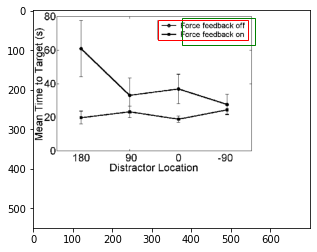

Actual bbox : [421  24 503  91]
Predicted bbox : [404.57385  84.49235 557.89545 131.22055]


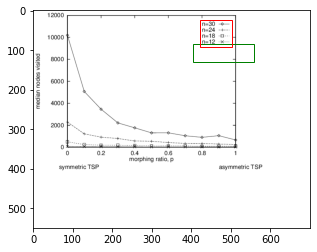

Actual bbox : [371  90 537 224]
Predicted bbox : [349.97974   62.175613 503.31088  173.4917  ]


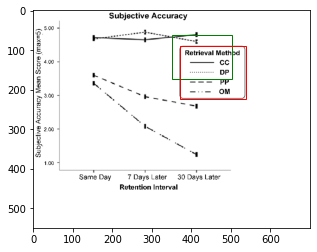

Actual bbox : [438  36 628  97]
Predicted bbox : [337.53912   94.463264 554.6787   164.29486 ]


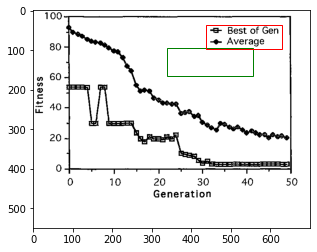

Actual bbox : [430  23 608 111]
Predicted bbox : [363.25568   19.203104 555.4689   120.91577 ]


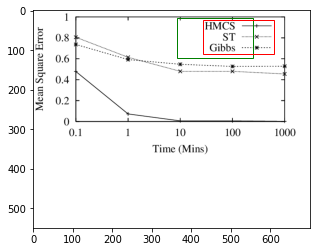

Actual bbox : [335  16 465  58]
Predicted bbox : [307.19897   57.529793 453.56158  111.81573 ]


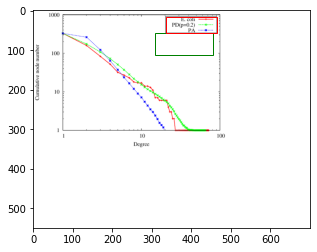

Actual bbox : [361   5 576 139]
Predicted bbox : [348.6435    17.944433 537.9403    90.756744]


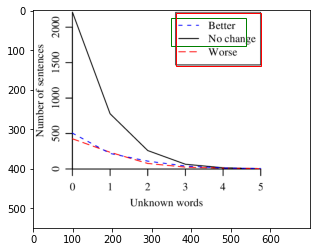

Actual bbox : [ 66  17 281  68]
Predicted bbox : [ 66.59562   19.437653 282.59082   88.840225]


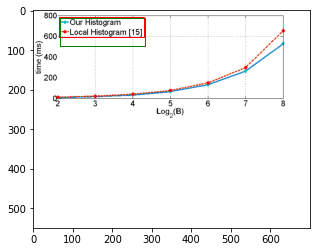

Actual bbox : [337  20 595  71]
Predicted bbox : [340.13245   20.632792 585.97986   70.064125]


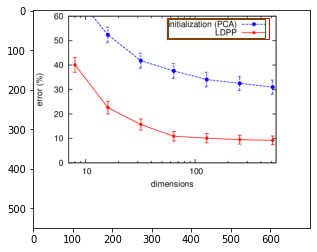

Actual bbox : [430   5 549  42]
Predicted bbox : [427.22357    15.1170225 531.98315    58.813335 ]


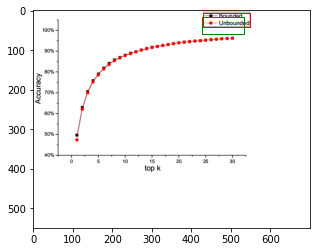

Actual bbox : [359  47 535 135]
Predicted bbox : [401.50888  89.29787 548.6197  206.1741 ]


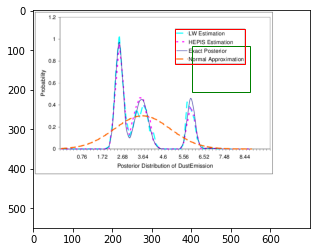

Actual bbox : [350  18 507  64]
Predicted bbox : [295.1126    15.348319 446.40897   61.818775]


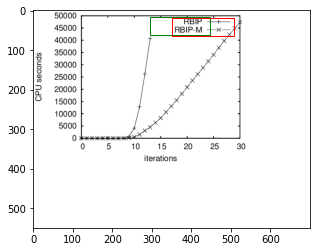

Actual bbox : [387  16 492  73]
Predicted bbox : [344.79565   31.509117 471.45547   78.47037 ]


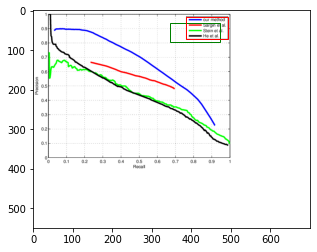

Actual bbox : [ 63  13 214  66]
Predicted bbox : [115.85264   28.44822  259.4074   107.599365]


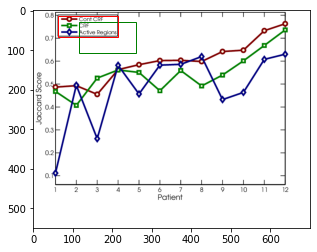

Actual bbox : [400   4 468 146]
Predicted bbox : [237.36024   30.626493 397.74515   98.297806]


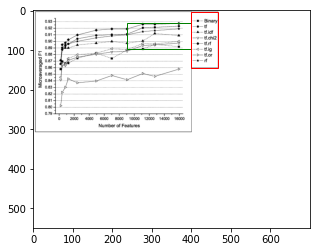

Actual bbox : [456  22 672 177]
Predicted bbox : [421.1783    16.587748 623.6993   158.95497 ]


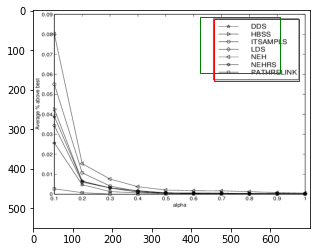

In [21]:
image_batch, gt_bbox_batch = next(it)

for i in range(batch_size):
    instance = (tf.constant([image_batch[i].numpy()]), tf.constant([gt_bbox_batch[i].numpy()]))
    plot_bounding_box(instance, model, prediction=True)

In [ ]:
# !zip -r EIoU_model.zip saved_model/

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !cp mae_EIoU_model.zip drive/MyDrive/